In [ ]:
# # Library for Data Manipulation
# import numpy as np
# import pandas as pd

# #Library for Data Visualization.
# import seaborn as sns
# import matplotlib.pyplot as plt
# # import hvplot

# %matplotlib inline
# sns.set_style("whitegrid")
# plt.style.use("fivethirtyeight")

# # Library for Statistical Modelling
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_recall_curve, roc_curve
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from xgboost import XGBClassifier
# # from lightgbm import LGBMClassifier
# # from catboost import CatBoostClassifier
# from sklearn.ensemble import AdaBoostClassifier

# print("==================== Packages Loaded ======================")


==================== Packages Loaded ======================


In [12]:
df = pd.read_csv("processed_datasets.csv")

✅ Best Params: {'C': 10000, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}

✅ Accuracy (Threshold = 0.15): 0.7993

✅ Classification Report (Custom Threshold):

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       247
           1       0.43      0.74      0.54        47

    accuracy                           0.80       294
   macro avg       0.69      0.78      0.71       294
weighted avg       0.86      0.80      0.82       294



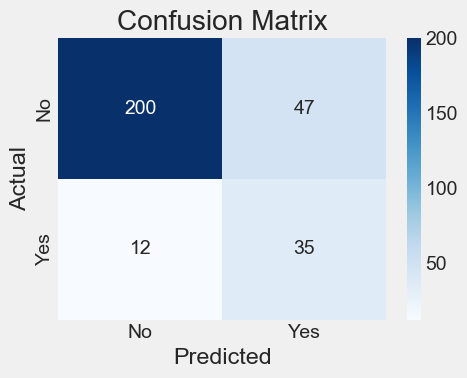

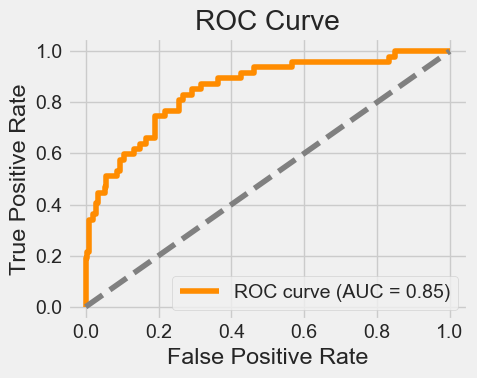

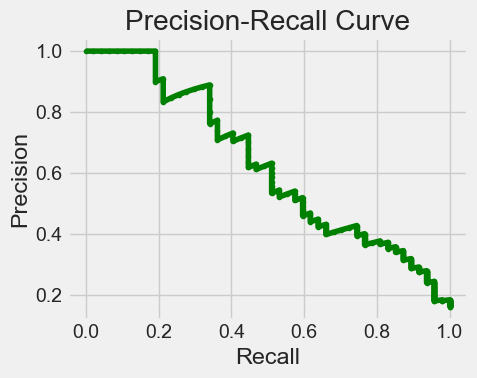

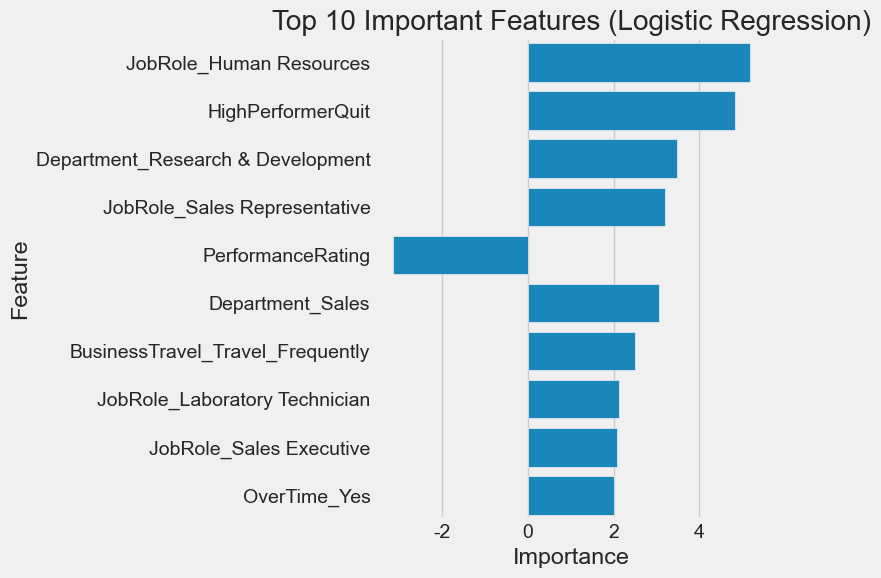

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# 1. 데이터 불러오기
df = pd.read_csv("processed_datasets.csv")  # 같은 디렉토리에 있어야 함

# 2. 피처/타겟 나누기
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

# 3. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 하이퍼파라미터 탐색 설정 (Grid Search)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [500, 1000]
}

grid_search = GridSearchCV(
    LogisticRegression(), param_grid,
    cv=5, scoring='f1', n_jobs=-1
)
grid_search.fit(X_train, y_train)

# 5. 최적 모델 추출 및 예측 확률 계산
best_model = grid_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]

# 6. Threshold 조정 (Attrition 평균 비율 = 약 16%)
threshold = 0.15
y_pred_custom = (y_prob >= threshold).astype(int)

# 7. 성능 평가
acc = accuracy_score(y_test, y_pred_custom)
report = classification_report(y_test, y_pred_custom)

print("✅ Best Params:", grid_search.best_params_)
print(f"\n✅ Accuracy (Threshold = {threshold}): {acc:.4f}")
print("\n✅ Classification Report (Custom Threshold):\n")
print(report)

# 8. 모델 및 피처 저장 (옵션)
os.makedirs("model", exist_ok=True)
joblib.dump(best_model, "model/logistic_attrition_model.pkl")
joblib.dump(X.columns.tolist(), "model/feature_columns.pkl")

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("model/confusion_matrix.png")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("model/roc_curve.png")
plt.show()

# ✅ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, marker='.', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.savefig("model/precision_recall_curve.png")
plt.show()

# ✅ Feature Importance (Coefficient 크기 시각화)
importance = best_model.coef_[0]
features = X.columns

coef_df = pd.DataFrame({
    "Feature": features,
    "Importance": importance
}).sort_values(by="Importance", key=abs, ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=coef_df.head(10))
plt.title("Top 10 Important Features (Logistic Regression)")
plt.tight_layout()
plt.savefig("model/feature_importance.png")
plt.show()
